# 3.2 Motor de Indução - Partida

Exemplo de simulação da partida de um motor de indução. 
Utiliza-se a transformada de Park e o método de Heun (integração numérica trapezoidal).

In [1]:
Vl=380; %tensão de linha
r1=0.5944;
x1=1.5576;
xm=73.1489;
r2=1.2296;
x2=1.7937;
J=0.097+0.1; % momento de inércia (motor+carga)
T_L=20; % torque da carga [Nm]
ws=2*pi*60; % velocidade angular
P=4; % número de pólos

h=1e-4; % intervalo de tempo
Tfinal=1; % tempo final da simulação [s]
n=round(Tfinal/h)+1;

% Inicializando as variáveis
psi_qs = zeros(1,n);
psi_ds = zeros(1,n);
psi_qr = zeros(1,n);
psi_dr = zeros(1,n);
Wrm = zeros(1,n);
i_qs = zeros(1,n);
i_ds = zeros(1,n);
i_qr = zeros(1,n);
i_dr = zeros(1,n);
Wr = zeros(1,n);
Tem = zeros(1,n);
i_as = zeros(1,n);
i_bs = zeros(1,n);
i_cs = zeros(1,n);
i_ar = zeros(1,n);
i_br = zeros(1,n);
i_cr = zeros(1,n);
v_qs = zeros(1,n);
v_ds = zeros(1,n);
v_qr = zeros(1,n);
v_dr = zeros(1,n);
TL = zeros(1,n);
B = [1 0 1;
-0.5 -sqrt(3)/2 1;
-0.5 sqrt(3)/2 1];
Lls=x1/ws;
Llr=x2/ws;
M=xm/ws;
Lss=Lls+M;
Lr2=Llr+M;
D=Lss*Lr2-M^2;

% integração numérica
time=0;
k(1)=0;
k(2)=0;
TL(1)=T_L;
TL(2)=T_L;
for i=3:n
    time=time+h;
    k(i)=k(i-1)+1;
    TL(i)=T_L; % torque da carga - poderia ser substituído por uma equação (cte seria um elevador, por exemplo)
    va=Vl*sqrt(2/3)*sin(ws*time); % função da tensão va no tempo
    vb=Vl*sqrt(2/3)*sin(ws*time-2*3.1415/3); % defasada de -120º
    vc=Vl*sqrt(2/3)*sin(ws*time+2*3.1415/3); % defasada de 120º
    % realizando a transformada de Park, converte-se o sistema trifásico para os eixos q e d, defasados em 90°
    v_qs(i)=2/3*(va-((vb+vc)/2)); % 
    v_ds(i)=2/3*((-vb+vc)*sqrt(3)/2);
    psi_ds(i) = psi_ds(i-1)+(h*(v_ds(i-1)-r1*i_ds(i-1))); % fluxo concatenado do estator no eixo d
    psi_qs(i) = psi_qs(i-1)+(h*(v_qs(i-1)-r1*i_qs(i-1))); % fluxo concatenado do estator no eixo q
    psi_dr(i) = psi_dr(i-1)+(h*(v_dr(i-1)-r2*i_dr(i-1)-Wr(i-1)*psi_qr(i-1))); % fluxo concatenado do rotor no eixo d
    psi_qr(i) = psi_qr(i-1)+(h*(v_qr(i-1)-r2*i_qr(i-1)+Wr(i-1)*psi_dr(i-1))); % fluxo concatenado do rotor no eixo q
    Wrm(i) = Wrm(i-1)+(h*((Tem(i-1)-TL(i-1))/J)); % integrando a nova velocidade
    i_ds(i)=(Lr2*psi_ds(i)-(M*psi_dr(i)))/D; 
    i_qs(i)=(Lr2*psi_qs(i)-(M*psi_qr(i)))/D;
    i_dr(i)=(Lss*psi_dr(i)-(M*psi_ds(i)))/D;
    i_qr(i)=(Lss*psi_qr(i)-(M*psi_qs(i)))/D;
    Tem(i)= 3/2*(P/2)*(psi_qr(i)*i_dr(i)-psi_dr(i)*i_qr(i)); % torque desenvolvido pelo motor
    Wr(i) = (P/2)*Wrm(i);
    i_as(i)=i_qs(i);
    i_bs(i)=-i_qs(i)/2+(i_ds(i)*(-sqrt(3)/2));
    i_cs(i)=-i_qs(i)/2+(i_ds(i)*(sqrt(3)/2));
end
t=0:h:Tfinal;

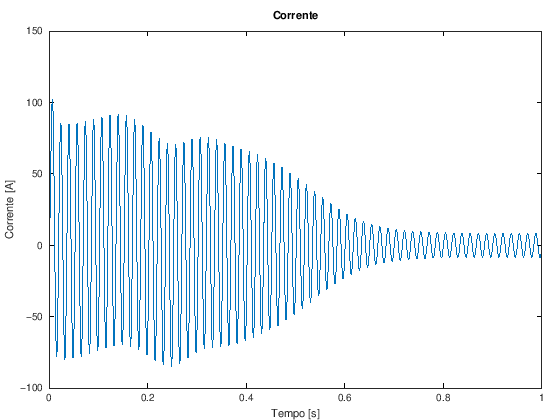

In [2]:
plot(t,i_as)
ylabel('Corrente [A]');
xlabel('Tempo [s]');
title('Corrente');

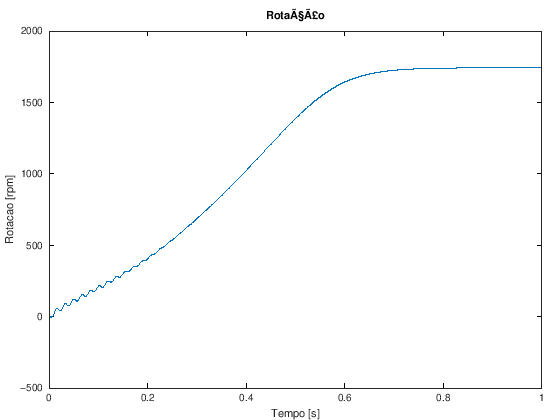

In [3]:
plot(t,(2/P)*Wr/2/pi*60)
ylabel('Rotacao [rpm]');
xlabel('Tempo [s]');
title('Rotação');

### Função de Média Móvel
    Fonte:  Glen (2021). Moving Average Function (https://www.mathworks.com/matlabcentral/fileexchange/41859-moving-average-function), MATLAB Central File Exchange. Retrieved February 9, 2021. 

In [4]:
function result=movingmean(data,window,dim,option)
%Calculates the centered moving average of an n-dimensional matrix in any direction. 
%   result=movingmean(data,window,dim,option)
%   Inputs: 
%   1)  data = The matrix to be averaged. 
%   2)  window = The window size.  This works best as an odd number.  If an even 
%       number is entered then it is rounded down to the next odd number.  
%   3)  dim = The dimension in which you would like do the moving average.
%       This is an optional input.  To leave blank use [] place holder in
%       function call.  Defaults to 1.
%   4)  option = which solution algorithm to use.  The default option works
%       best in most situations, but option 2 works better for wide
%       matrices (i.e. 1000000 x 1 or 10 x 1000 x 1000) when solved in the
%       shorter dimension.  Data size where option 2 is more efficient will 
%       vary from computer to computre.This is an optional input.  To leave  
%       blank use [] place holder in function call.  Defaults to 1.
% 
%   Example:  
%   Calculate column moving average of 10000 x 10 matrix with a window size 
%   of 5 in the 1st dimension using algorithm option 1.
%   d=rand(10000,10);
%   dd=movingmean(d,5,1,1);
%           or
%   dd=movingmean(d,5,[],1);
%           or
%   dd=movingmean(d,5,1,[]);
%           or
%   dd=movingmean(d,5,1);
%           or
%   dd=movingmean(d,5,[],[]);
%           or
%   dd=movingmean(d,5);
%
%   Moving mean for each element uses data centered on that element and
%   incorporates (window-1)/2 elements before and after the element.
%
%   Function is broken into two parts.  The 1d-2d solution, and the
%   n-dimensional solution.  The 1d-2d solution is the fastest that I have 
%   been able to come up with, whereas the n-dimensional solution trades
%   speed for versatility.
%
%   Function includes some code at the end so that the user can do their
%   own speed testing using the TIMEIT function.
%
%   Has been heavily tested in 1d-2d case, and lightly tested in 3d case.
%   Should work in n-dimensional space, but has not been tested in more 
%   than 3 dimensions other than to make sure it does not return an error.
%   Has not been tested for complex inputs.
%errors for leaving out data or window inputs
if ~nargin
    error('no input data')
end
if nargin<2
    error('no window size specified')
end
%defaults the dimension and option to 1 if it is not specified
if nargin<3 || isempty(dim)
    dim=1;
end
if nargin<4 || isempty(option)
    option=1;
end
%rounds even window sizes down to next lowest odd number
if mod(window,2)==0
    window=window-1;
end
%Calculates the number of elements in before and after the central element
%to incorporate in the moving mean.  Round command is just present to deal
%with the potential problem of division leaving a very small decimal, ie.
%2.000000000001.
halfspace=round((window-1)/2);
%calculates the size of the input data set
n=size(data);
%returns error messages for incorrect inputs
if mod(dim,1)
    error('dimension number must be integer')
end
if ((ndims(data)<=2 && (option<1 || option>3)) || (ndims(data)>=3 && (option<1 ||option>2))) ...
       || mod(option,1)
    error('invalid algorithm option')
end
if mod(window,1)
    error('window size must be integer')
end
if dim>ndims(data)
    error('dimension number exceeds number of dimensions in input matrix')
end
if dim<1
    error('dimension number must be >=1')
end
if n(dim)<window
    error('window is too large')
end
if ndims(data)<=2
    %Solution for 1d-2d situation.  Uses vector operations to optimize
    %solution speed.
    
    %To simplify algorithm the problem is always solved with dim=1.
    %If user input is dim=2 then the data is transposed to calculate the
    %solution in dim=1
    if dim==2
        data=data';
    end
  
    
    %The three best solutions I came up to for the 1d-2d problem.  I kept
    %them in here to preserve the code incase I want to use some of it
    %again.  I have found that option 1 is consistenetly the fastest.
    %option=1;
    switch option
        case 1
            %option 1, works best for most data sets
            
            %Computes the beginning and ending column for each moving
            %average compuation.  Divide is the number of elements that are
            %incorporated in each moving average.
            start=[ones(1,halfspace+1) 2:(n(dim)-halfspace)];
            stop=[(1+halfspace):n(dim) ones(1,halfspace)*n(dim)];
            divide=stop-start+1;
     
            %Calculates the moving average by calculating the sum of elements
            %from the start row to the stop row for each central element,
            %and then dividing by the number of elements used in that sum
            %to get the average for that central element.
            %Implemented by calculating the moving sum of the full data
            %set.  Cumulative sum for each central element is calculated by
            %subtracting the cumulative sum for the row before the start row
            %from the cumulative sum for the stop row.  Row references are
            %adusted to take into account the fact that you can now
            %reference a row<1.  Divides the series of cumulative sums for
            %by the number of elements in each sum to get the moving
            %average.
            CumulativeSum=cumsum(data);
            temp_sum=CumulativeSum(stop,:)-CumulativeSum(max(start-1,1),:);
            temp_sum((start==1),:)=bsxfun(@plus,temp_sum((start==1),:),data(1,:));
            result=bsxfun(@rdivide,temp_sum,divide');
            
        case 2
            %option 2, Can be faster than option 1 in very wide matrices
            %(i.e. 100 x 1000 or l000 x 10000) when solving in the shorter
            %dimension, but in general it is slower than option 1.
            %Uses a for loop to calculate the data from the start row to
            %the stop row, and then divides by the number of rows
            %incorporated.
            
            result=zeros(size(data));
            for i=1:n(dim)
                start=max(1,i-halfspace);
                stop=min(i+halfspace,n(dim));
                result(i,:)=sum(data(start:stop,:),1)/(stop-start+1);
            end
            
        case 3
            %option 3, Creates a sparse matrix to indicate which rows to include
            %data from for the moving average for each central element.
            %Uses matrix multiplication to calculte the cumulative sum for 
            %each central element.  Then divides by the number of elements
            %used in each cumulative sum to get the average for each
            %central element.
            %Elegant but slow.  I think this is because bsxfun has to do
            %a lot of matrix replication.  Also, it is easy for the use matrix to
            %exceed the maximum matrix dimensions for MATLAB.
     
            start=[ones(1,halfspace+1) 2:(n(dim)-halfspace)];
            start=start';
     
            stop=[(1+halfspace):n(dim) ones(1,halfspace)*n(dim)];
            stop=stop';
     
            divide=stop-start+1;
    
            baseline=1:n(dim);
     
            use=sparse(n(dim),n(dim),n(dim)*max(divide));
            use=(bsxfun(@ge,baseline,start) & bsxfun(@le,baseline,stop));
     
            %uses matrix multiplication instead of repmat or bsxfun, slower than
            %using bsxfun
            %baseline_mat=ones(n(dim),1)*baseline;
            %start_mat=start*ones(1,n(dim));
            %stop_mat=stop*ones(1,n(dim));
        
            %use=(baseline_mat>=start_mat & baseline_mat<=stop_mat);
            %use=sparse(use);
    
            result=bsxfun(@rdivide,use*data,divide);
    end
    %Transposes the matrix if the problem was solved in dimension=2 so that
    %the ouput is correctly oriented. Undoes the initial transposition.
    if dim==2
        result=result';
    end
else
    %Solution of the n-dimensional problem.  This solution is 
    %slower than the 1d-2d solution in a 1d-2d problem, but depending on the
    %dimensions of the input array can be faster for the same number of
    %elements in a 3d+ problem (ie. 1000000 x 1 vs 100 x 100 x 100).  
    %Either way it is much more versatile.  The algorithm can solve for a 
    %moving average in any dimension of an n-dimension input matrix.
    
    %Two solutions of the problem.  In general option 1 is faster than
    %option 2, but I think that for some matrix sizes option 2 will be
    %faster.  
    %option=1;
    switch option
 
        case 1
            %Option 1 is based on option 1 for the 1d-2d solution.  In
            %general this is the faster solution.  For a more extensive
            %explanation of the code see option 1 in the 1d-2d section.
            
            %Calculates the start and stop positions, and creates a vector
            %of how many elements are in each moving sum.
            start=[ones(1,halfspace+1) 2:(n(dim)-halfspace)];
            stop=[(1+halfspace):n(dim) ones(1,halfspace)*n(dim)];
            divide=stop-start+1;
            
            %Reorients the start, stop, and divide vectors in the direction
            %of the specified dimension.
            %Creates a vector to use to reshape the start, stop, and divide
            %vectors.  Puts one in for the each dimension excpet for the
            %specified dimension, which is set to the size of the input
            %matrix in that direction.  ex. [1 1 100 1] for a 
            %100 x 100 x 100 x 100 input matrix, solving in the 3rd
            %dimension.
            temp_dims=ones(size(n));
            temp_dims(dim)=n(dim);
            
            %inv_temp_dims=n;
            %inv_temp_dims(dim)=1;
            
            %Uses the vector created above to reorient the start, stop, and
            %divide vectors in the correct direction.
            start=reshape(start,temp_dims);
            stop=reshape(stop,temp_dims);
            divide=reshape(divide,temp_dims);
            
            %Calculates the cumulative sum of the data in the specified
            %direction.
            CumulativeSum=cumsum(data,dim);
            
            %I have found the most versatile way of writing an algorithm
            %that will solve in any dimension of an unknown dimensional
            %input matrix is to built some functions with text that is
            %based on the input parameters.
            
            %This text builds the function that subtracts the cumulative
            %sum at the stop position from the cumulative sum at one
            %element before the start position for each central element.
            %Compensates for not have an index less than 1.
            function_text=['@(CumulativeSum,start,stop) CumulativeSum(' repmat(':,',1,dim-1) 'stop,' repmat(':,',1,ndims(data)-dim)];
            function_text=function_text(1,1:end-1);
            function_text=[function_text ')-CumulativeSum(' repmat(':,',1,dim-1) 'max(1,start-1),' repmat(':,',1,ndims(data)-dim)];
            function_text=function_text(1,1:end-1);
            function_text=[function_text ')'];
            
            %Converts the string above into an anonymous function with the
            %handle "difference".
            difference=str2func(function_text);
            
            %Runs the function built above to determine the cumulative sum
            %between start and stop.
            temp_sum=difference(CumulativeSum,start,stop);
            
            %Text to make a function that corrects for the fact that the
            %cumulative sum for moving sums that start at position 1 have
            %the first data position subtracted out.  This is becasue you
            %can not have a matrix index less than 1.  Uses bsxfun to
            %multiply start==1 by the first plane of data (in the
            %appropriate dimension) and then adding that to temp_sum.  Need
            %to do it this way vs using something based on reshaping
            %data(repmat(start,inv_temp_dims)==1) because the correction
            %needs to be the same size as temp_sum.  This is needed b/c I
            %do not know how to use text to set the variable elements that
            %will accept the addition (i.e.
            %temp_sum(:,:,1:sum(start==1))=).
            correction_text=['@(temp_sum,start,data) temp_sum+bsxfun(@times,start==1,data(' repmat(':,',1,dim-1) '1,' repmat(':,',1,ndims(data)-dim)];
            correction_text=correction_text(1,1:end-1);
            correction_text=[correction_text '))'];
            
            %Converts the above text into a function.
            correction=str2func(correction_text);
            
            %Applies the correction describe previously to the temp_sum
            %matrix
            temp_sum=correction(temp_sum,start,data);
            
            %Divides the temp_sum matrix by the divide vector to
            %calculate the moving average for each central elemant.
            result=bsxfun(@rdivide,temp_sum,divide);
        
        case 2
            %An older solution to the n-dimensional moving average problem.
            
            %Based on the approach in option 2 in the 1d-2d solution.
            %Depending on matrix dimensions this might be faster than
            %option 1 in certain situations (ex input matrix size is 10 x
            %1000 x 1000 and the average is done in dimension 1).
            
            %Builds a string for the function used in the for loop.
            %Basiscally it builds something like sum(data(:,:,start:stop,:),3) but
            %is able to work in any dimensions and have start:stop be in
            %any of those dimensions.
            function_text='@(start,stop,dim) sum(data(';
            for i=1:ndims(data)
                if i==dim 
                    if i~=1
                        function_text=[function_text ',start:stop'];
                    else
                        function_text=[function_text 'start:stop'];
                    end
                else
                    if i~=1
                        function_text=[function_text ',:'];
                    else
                        function_text=[function_text ':'];
                    end
                end 
            end       
       
            function_text=[function_text '),dim)'];
            
            %Converts the text above into a function
            moving_sum=str2func(function_text);
                  
            %For loop determines the start position, stop position, and
            %number of elements for the moving average of each central
            %element.  Calculates the moving sum for each central element
            %in that position, and divides by the number of elements to get
            %the moving average.  
            for i=1:n(dim)
                start=max(1,i-halfspace);
                stop=min(i+halfspace,n(dim));
                
                temp_m=moving_sum(start,stop,dim)/(stop-start+1);
        
                %This was the most versatile way of reassembling all of the
                %moving average matrices back into the final output matrix,
                %although it is slow b/c the result matrix keeps resizing.
                if i==1
                    result=temp_m;
                else
                    result=cat(dim,result,temp_m);
                end
            end
        
         
            
    end
end
%code for speed testing
%generates a series of random vectors with 10 to 10000000 cells and then
%times the moving average at each size.  Time for each input size is
%stored.
%1d-2d timer test
%data_power=[1 2 3 4 5 6 7];
%data_size=10.^data_power;
%window=5;
%dim=1;
%time=zeros(size(data_size));
%for i=1:size(data_size,2)
%   data=rand(data_size(i),1);
%   f=@() movingmean(data,window,dim);
%   time(i)=timeit(f,1);
%end
%3d timer test
%data_power=[1 2 3];
%data_size=10.^data_power;
%window=5;
%dim=1;
%time=zeros(size(data_size));
%for i=1:size(data_size,2)
%   data=rand(data_size(i),100,100);
%   f=@() movingmean(data,window,dim);
%   time(i)=timeit(f,1);
%end
end

## Plotando usando Média Móvel

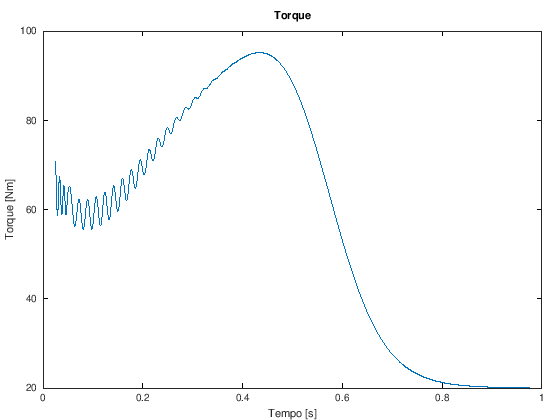

In [5]:
plot(movingmean(t',6/60/h),movingmean(Tem',6/60/h)) %utilizando uma média móvel de 6 períodos (1/f)
ylabel('Torque [Nm]');
xlabel('Tempo [s]');
title('Torque');

## Efeito da Média Móvel no valor máximo do Torque

In [6]:
[Torque,b]=max(Tem(3000:end)); % cortando o transitório inicial
tempo=t(b+3000);
Torque,tempo
[Torque_mm,b]=max(movingmean(Tem',6/60/h)); 
t1=movingmean(t',6/60/h);
tempo_mm=t1(b);
Torque_mm,tempo_mm

Torque =  96.200
tempo =  0.43760
Torque_mm =  95.179
tempo_mm =  0.43440


# Referência

https://www.mathworks.com/matlabcentral/fileexchange/59568-induction-motor-modelling?s_tid=srchtitle

# Tarefa

1. Simule um dos motores que você identificou os parâmetros na atividade anterior e compare com os dados fornecidos pelo fabricante.

2. Uma plaina possui uma curva de torque versus velocidade do tipo linear (partindo do zero), sendo que para um torque de 50 N.m a rotação é de 1700 rpm. No acionamento, especificou-se um motor de indução trifásico que apresenta as seguintes características: 2 pares de pólos; Torque mecânico de saída igual a T_m=300-0,0084 ω^2; O momento de inércia do conjunto é  J_m= 5 kg.m2. Conectando o motor a plaina, qual a velocidade angular de operação? Qual a perda elétrica estimada?

3. Considere o mesmo acionamento do exercício anterior e calcule o tempo de partida direta (pode usar os valores médios) e a capabilidade de partir com uma chave estrela-triângulo se o motor possuir um tempo de rotor bloqueado de 8s.